# Classification of quantum states with high dimensional entanglement 

### This version bypasses circuit building, transpile and run

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
from scipy.signal import savgol_filter
import time
from qiskit.tools.monitor import job_monitor

In [2]:
from o_utils import ora # classifier utilities
from o_plot import opl # utilities for result plot
from c_utils import new_cut # circuit building utilities

In [3]:
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)

#markdown for safety on demo
def json_dic_dumper(dic, dic_name):
    with open(data_directory+dic_name+'.json', 'w') as f:
        json.dump(dic,f)   

In [4]:
# common code for calling the classifier for ideal device and for real devices
def add_single_dic(target_data_list):
    start_time = time.time()                
           
    print("started",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name)
    
    # added for D,S,M choice. Mainstream : mixed set of 20 states
    first = 0
    last = nb_states
    if unique_char == "D":
        last = int(nb_states/2)
    elif unique_char == "S":
        first = int(nb_states/2)
    
    # get the classifier error curve in function of the number of shot and the "safe shot number" 
    error_curve, safe_rate, ernb = ora.provide_error_curve(PD_model=model_dic[model_name][first:last,:],
                                                   PD_test=PD_test[first:last,:],
                                                   trials=trials,
                                                   window=window,
                                                   epsilon=epsilon,
                                                   max_shots=max_shots,
                                                   pol=pol,
                                                   verbosality=verbosality)

    tail = savgol_filter(ernb, window, pol, axis=0)
    len_curve = len(error_curve)
    safe_shot_nb = len_curve - int((window-1)/2) # OK
    print('safe_shot_nb',safe_shot_nb, 'safe_rate',safe_rate, "nb trials:",trials)
    err_rates = tail[int((window-1)/2),:]/trials 
    err_rate_max = np.max(err_rates)
    err_rate_min = np.min(err_rates)
    r=4
    print("savgol interpolated error rate mean:", np.round(np.mean(err_rates),r),
          "min:", np.round(err_rate_min,r),
          "max:", np.round(err_rate_max,r), "for",
          [ien for ien, jen in enumerate(err_rates) if jen == err_rate_max])
    end_time = time.time()
    
    #save the data in a list of dictionaries :
    single_dic={"project":mitig_name,
                "id_gates":id_gates,
                "mitigation":mit_str,
                "model":model_name,
                "metric":o_metric, "device":project_device,                              
                "curve_length":len_curve, 
                "shots": safe_shot_nb,
                "shots_rate": safe_rate,                                                                                    
                "error_curve":error_curve,
                "trials":trials,"window":window,
                "epsilon":epsilon,"SG_pol": pol,                         
                "computation_time":end_time-start_time,
                "time_completed":time.strftime('%d/%m/%Y %H:%M:%S'),
                "trials":trials,
                "QV": QV_dic[project_device],
                "fidelity": fidelity_dic[project_device],
                "error_nb":ernb}
    target_data_list.append(single_dic)
    
    print("completed",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name,"\n")

## Set up the simulator and layout for 5 qubits

In [5]:
simulator = Aer.get_backend('qasm_simulator')

In [6]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [7]:
short_version = True
#program_name="QAD" # 1st pilot project GHZ Psi+ / W Phi+
program_name="AL2" # 2d pilot project W Psi+ / Wbar Phi+
Flag_char = "DS" # this for a mix of two types of separable states
if len(Flag_char) >= 2:
    unique_char = "M"
else:
    unique_char = Flag_char

In [8]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,
                "ibmqx2": 0.627392, 'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974,
                "ibmqx2": 0.359528, 'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0, 
          "ibmqx2": 8.0, 'ibmq_santiago': 32.0, 'ibmq_vigo': 16.0, 'ideal_device': np.inf}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor',  'ideal_device': "Ide"}

In [9]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [10]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [11]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [12]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [13]:
len(meas_calibs)

32

In [14]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
if used_qubits == 5:
    q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]
else:
    print("work in progress - meanwhile please provide the list of permutations")

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [15]:
# try loading the dictionary of results if its creation was skipped
if short_version == True:
    ideal_dic = json_dic_loader("ideal_dic_"+project_name)

In [16]:
nb_states = len(ideal_dic)
nb_labels = len(list(ideal_dic.values())[0])
s_sim = sum(list(ideal_dic.values())[0].values())

In [17]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print("first and last state probability distributions:")
print(np.round(np.vstack((PD_ideal[0:1,:],PD_ideal[-1:,:])),4)) 

first and last state probability distributions:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1667
  0.1667 0.     0.1667 0.     0.     0.     0.     0.1667 0.1667 0.
  0.1667 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.1667 0.     0.     0.1667 0.     0.     0.     0.
  0.1667 0.     0.     0.1667 0.1667 0.     0.     0.1667 0.     0.
  0.     0.    ]]


## Monte Carlo simulation for the ideal device

In [20]:
# here will be appended the data we want for the curve plot 
ideal_data_list=[]

###  you may skip this cell and get stored curves by running the next cell

In [ ]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary (readme file):
trials=100 # should be 10000 if not demo
window=5 # shorter window than for the real device counts
epsilon = .001
min_shots = 5
max_shots = 100
pol=2

subset = None # variable not used here
verbosality = 5 # printing step for intermediate results when increasing the experiment shot number 

PD_test = PD_ideal
mitigation_dic =  {"Na": None} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    if mitigation != None: # thus only for counts on real device
        PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    for o_metric in o_metrics_desired:           
            for model_name in model_dic.keys():
                add_single_dic(ideal_data_list)                

markdown for safety
json_dic_dumper(ideal_data_list,"ideal_device_data_list_"+project_name)

In [21]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(ideal_data_list) == 0:
    ideal_data_list = json_dic_loader("ideal_device_data_list_"+project_name)

<Figure size 432x288 with 0 Axes>

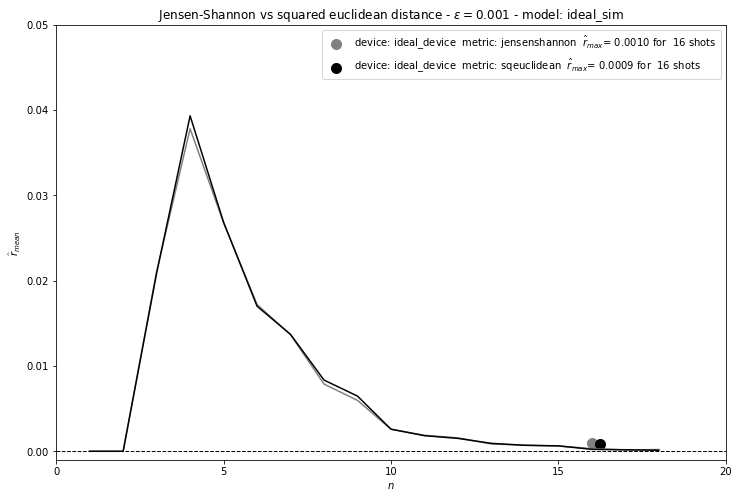

In [22]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors the unsmoothed values 
opl.plot_curves(ideal_data_list,np.array([0,1]),
            "Jensen-Shannon vs squared euclidean distance - $\epsilon=0.001$" , 
             ["model"], ["device","metric"],
             right_xlimit = 20, bottom_ylimit = -0.001, top_ylimit = 0.05)

# Real device section

In [23]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [24]:
project_device = 'ibmq_valencia'# you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Val


In [25]:
#determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [26]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because the calibration results were stored as dictionary
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
cal_results_dic = json_dic_loader("cal_results_dic_"+mitig_name) 

In [27]:
if 'date' in cal_results_dic.keys():
    str(cal_results_dic['date'])

In [28]:
cal_results = fake_cal_results.from_dict(cal_results_dic)

In [29]:
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.794262 for ibmq_valencia


In [30]:
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Val_M000


### Load  the transpiled circuits that were actually run 
##### legacy: valid only for the GHZ Psi+ / W Phi- combination
otherwise go instead to:
#### "Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier"


In [31]:
#changing keys of dictionary for merging:    
def key_change(ini_dict, i_subset):
    ini_list = []
    len_ini = len(ini_dict)
    for i in range(len_ini):
        ini_list.append(str(i+i_subset*len_ini))
    return dict(zip(ini_list, list(ini_dict.values()))) 

In [32]:
if program_name == "QAD":
    #retrieve the data corresponding to the 1st project
    lfc = list(Flag_char)
    circ_ideal =[]
    empirical_dic = {}

    for i_subset, subset in enumerate(lfc):
        qasm_circs_dic = json_dic_loader('qasm_circs_dic_QAD_'+device_name+'_'+ subset + zfilled)
        j=0 # j included for project with several transpilation sessions for each device - not used here
        qasm_circs = qasm_circs_dic[str(j)]
        nb_circs = len(qasm_circs)        
        for i_circs in range(nb_circs):
            circ_ideal.append(QuantumCircuit().from_qasm_str(qasm_circs[i_circs]))
        empirical_dic = {**empirical_dic,
                     **key_change(json_dic_loader("experimental"+"_"+mitig_name +"_"\
                                  +subset+zfilled), i_subset)}
    test_dic = copy.deepcopy(empirical_dic)
    #nb_states = len(circ_ideal)

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [33]:
project_name

'AL2_Val_M000'

In [34]:
if program_name == "AL2":
    empirical_dic = json_dic_loader('experimental_'+project_name) 
    test_dic = json_dic_loader('test_'+project_name) 

In [35]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        
        void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
        try:
            counts_results_real_test = tot_res[str(test_cqi)]
        except KeyError as error:            
            counts_results_real_test = tot_res[test_cqi]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [36]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix  

In [37]:
# We need to create a first matrix version. It will then vary for each considered set of distribution
mitigation = False
PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter) 
print("first and last state probability distributions:")
print(np.round(np.vstack((PD_exper[0:1,:],PD_exper[-1:,:])),3)) 

first and last state probability distributions:
[[0.003 0.014 0.013 0.    0.017 0.001 0.001 0.001 0.031 0.096 0.078 0.003
  0.104 0.003 0.005 0.004 0.043 0.142 0.123 0.004 0.159 0.005 0.005 0.009
  0.013 0.039 0.033 0.002 0.043 0.001 0.002 0.001]
 [0.007 0.002 0.002 0.008 0.016 0.002 0.002 0.012 0.033 0.007 0.007 0.025
  0.147 0.022 0.026 0.142 0.015 0.003 0.004 0.011 0.064 0.011 0.009 0.062
  0.128 0.021 0.02  0.083 0.048 0.01  0.01  0.04 ]]


In [38]:
if program_name == "QAD":
    PD_test = copy.deepcopy(PD_exper)
elif program_name == "AL2":
    mitigation = False
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    print("first and last state probability distributions:")
    print(np.round(np.vstack((PD_test[0:1,:],PD_test[-1:,:])),3)) 

first and last state probability distributions:
[[0.005 0.013 0.011 0.    0.016 0.    0.    0.    0.032 0.094 0.078 0.002
  0.103 0.004 0.005 0.006 0.048 0.138 0.116 0.004 0.16  0.006 0.007 0.007
  0.016 0.039 0.032 0.001 0.048 0.002 0.002 0.003]
 [0.011 0.001 0.003 0.009 0.014 0.003 0.004 0.016 0.033 0.008 0.009 0.025
  0.141 0.024 0.024 0.139 0.014 0.003 0.002 0.01  0.066 0.011 0.012 0.055
  0.127 0.019 0.021 0.09  0.048 0.008 0.01  0.039]]


## Monte Carlo simulation for the real device

In [41]:
# here will be appended the data we want for the final plot of this notebook
empirical_data_list=[]

###  you may want to skip this cell and get stored curves by running the next cell

In [ ]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary notebook:
trials=100
window=11
epsilon = .001
max_shots = 500
pol=2

verbosality = 10 # printing step for intermediate results when increasing the experiment shot number 

# In this section you can easily make your choice of combinations
# mitigation or not, metric and model 

mitigation_dic =  {"no":False, "yes" : True} 
#mitigation_dic =  {"no":False} 
#mitigation_dic =  {"yes" : True} 

o_metrics_desired = ['jensenshannon', 'sqeuclidean']
#o_metrics_desired = ['jensenshannon']
#o_metrics_desired = ['sqeuclidean']

model_dic = {"empirical": PD_exper, "ideal_sim": PD_ideal}
#model_dic = {"empirical": PD_exper}
#model_dic = {"ideal_sim": PD_ideal}

# Obtain a sequence of results in form of a list of dictionaries

for mit_str, mitigation in mitigation_dic.items():
    # here we toggle PD_exper as we toggled mitigation status
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    for o_metric in o_metrics_desired:
        print(project_name, model_dic.keys(), o_metric)        
        for model_name in model_dic.keys():
            add_single_dic(empirical_data_list)

markdown fo security
json_dic_dumper(empirical_data_list,'Tnemp_data_list_'+project_name)

In [42]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(empirical_data_list) == 0:
    empirical_data_list  = json_dic_loader('nemp_data_list_'+project_name) 

<Figure size 432x288 with 0 Axes>

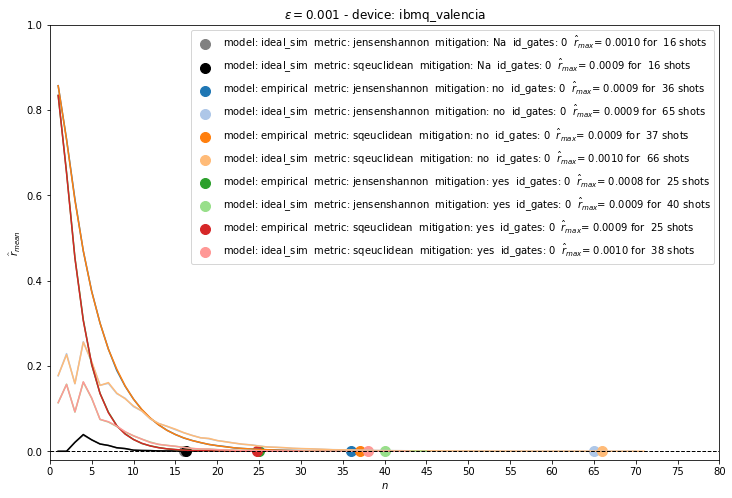

In [43]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors are the unsmoothed values 
opl.plot_curves(ideal_data_list + empirical_data_list,
                np.array(range(2+len(empirical_data_list))),
            "$\epsilon=0.001$" , ["device"],
            ["model","metric","mitigation","id_gates"],
            right_xlimit = 80, bottom_ylimit = -0.02, top_ylimit = 1)

In [44]:
import winsound
duration = 2000  # milliseconds 
freq = 800  # Hz
winsound.Beep(freq, duration)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table